In [1]:

%load_ext autoreload
%autoreload 2


In [91]:
from ase.io.extxyz import read_xyz
import numpy as np
from ase.atoms import Atoms
from ase.io.formats import index2range
from ase.io.cfg import read_cfg
from io import StringIO, UnsupportedOperation
from mtp import *
import os
from matplotlib import pyplot as plt
from quippy.potential import Potential
import pickle
from Ge_analysis import *
from Ge_calculation import *
import matplotlib.pyplot as plt
from matscipy.rings import ring_statistics
from datetime import datetime
import pymatgen.ext.matproj as mp
import pymatgen.io.ase as pase
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from numpy.random import normal
from ase.io.extxyz import write_xyz

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [ 'Helvetica', 'Arial', 'FreeSans', 'DejaVu Sans' ]

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 14
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['legend.borderaxespad'] = 1.5

plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 1.5

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.0

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.0

# Labelling

In [ ]:
GAP_18_dir = '/home/joe/Documents/Ge_od/Si_GAP_training/libAtoms-silicon-testing-framework-fc252cb/models/GAP'

In [ ]:
with open(GAP_18_dir + '/gp_iter6_sparse9k.xml.xyz', 'r') as f:
    GAP_18_db = list(read_xyz(f, index=slice(0,None)))

In [ ]:
with open('/home/joe/Documents/Ge_od/Potentials/Si_myDB_reduction_testing/Si_myDB_64_125_216_train.xyz', 'r') as f:
    myDB = list(read_xyz(f, index=slice(0,None)))

In [ ]:
GAP_18_pot = Potential(param_filename=GAP_18_dir+'/gp_iter6_sparse9k.xml')

In [ ]:
db = myDB
# db = GAP_18_db
for i, val in enumerate(db):

    GAP_18_pot.calculate(val, properties=['energies', 'forces', 'stress'])
    val.info['gap18_energy'] = GAP_18_pot.results['energy']
    val.info['gap18_virial'] = GAP_18_pot.results['virial']
    val.arrays['gap18_force'] = GAP_18_pot.results['forces']

In [ ]:
GAP_18_pot.calculate(GAP_18_db[0], properties=['energies', 'forces', 'stress'])
GAP_18_pot.results['virial']

In [ ]:
os.chdir('/home/joe/Documents/Ge_od/GAP_to_MTP')

In [ ]:
# with open('GAP_18_db_GAPlabelled_MTP4.pickle', 'wb') as f:
#     pickle.dump(GAP_18_db, f)

In [ ]:
with open('GAP_18_db_GAPlabelled.pickle', 'rb') as f:
    GAP_18_db = pickle.load(f)

In [ ]:
# with open('mydb_GAPlabelled_MTP4.pickle', 'wb') as f:
#     pickle.dump(myDB, f)

In [ ]:
with open('mydb_GAPlabelled_MTP4.pickle', 'rb') as f:
    myDB = pickle.load(f)

In [ ]:
# with open('GAP_18_db_GAPlabelled.cfg', 'w') as f:
#     write_cfg_db(f, GAP_18_db, energy_name='gap18_energy', force_name='gap18_force', virial_name='gap18_virial')

In [ ]:
# with open('GAP_18_db_DFTlabelled.cfg', 'w') as f:
#     write_cfg_db(f, GAP_18_db, energy_name='dft_energy', force_name='dft_force', virial_name='dft_virial')

## Writing all melt-quench data to DB for fitting


In [ ]:
sb = '/home/joe/Documents/Ge_od/Structure_databases'
mq_dirs = [os.path.join(sb, i) for i in ['run_64_atoms', 'run_125_atoms', 'run_216_atoms']]

mq_db = []

# for i in mq_dirs:
#     for j in os.listdir(i):
#         if 'run_' in j and 'castep' not in j:
#             for k in os.listdir(os.path.join(i, j, 'NPT', )):
#                 at = read_cfg(os.path.join(i,j,'NPT',k))
#                 at.info['rundir'] = j
#                 mq_db.append(at)
# l = len(mq_db)
# for i, val in enumerate(mq_db):
#
#     GAP_18_pot.calculate(val, properties=['energies', 'forces', 'stress'])
#     val.info['gap18_energy'] = GAP_18_pot.results['energy']
#     val.info['gap18_virial'] = GAP_18_pot.results['virial']
#     val.arrays['gap18_force'] = GAP_18_pot.results['forces']
#     if (i//l * 100) % 10 == 0:
#         print('{}% done'.format(i//l *100), datetime.now().time())

# with open('mq_db_GAP-18labelled.pickle', 'wb') as f:
#     pickle.dump(mq_db, f)

In [ ]:
with open('/home/joe/Documents/Ge_od/GAP_to_MTP/mqdb_GAP18labelled/mq_db_GAP-18labelled_3.pickle', 'rb') as f:
    mq_db_G18lab = pickle.load(f)


In [ ]:
# need to modify the stresses before writing them
for i in range(len(mq_db_G18lab)):
    v = -mq_db_G18lab[i].info['gap18_virial']*mq_db_G18lab[i].get_volume()
    mq_db_G18lab[i].info['gap18_virial'] = v


In [ ]:
# split into 80:20 test:training with entirely separate runs
rundirs = [int(i.info['rundir'][4:]) for i in mq_db_G18lab]
rundirs = np.array(rundirs)

In [ ]:
# keep back run numbers 8-27
v_args = np.array([[]]); t_args = np.array([[]])
for i in range(8,28):
    v_args = np.concatenate((v_args, np.where(rundirs==i)), axis=1)

for i in range(8):
    t_args = np.concatenate((t_args, np.where(rundirs==i)), axis=1)
for i in range(28,101):
    t_args = np.concatenate((t_args, np.where(rundirs==i)), axis=1)

In [ ]:
mq_db_G18lab_train = [mq_db_G18lab[int(i)] for i in t_args[0]]
mq_db_G18lab_val = [mq_db_G18lab[int(i)] for i in v_args[0]]

In [ ]:
# run_97 etc. didn't finish, so not exactly 80% but pretty close
len(mq_db_G18lab_train)/len(mq_db_G18lab_val)


len(mq_db_G18lab_train),len(mq_db_G18lab_val)

In [ ]:
# with open('mqdb_GAP18labelled/mqdb_GAP18labelled_train.cfg', 'w') as f:
#     write_cfg_db(f, mq_db_G18lab_train, energy_name='gap18_energy', force_name='gap18_force', virial_name='gap18_virial')

In [ ]:
# with open('mqdb_GAP18labelled/mqdb_GAP18labelled_validate.cfg', 'w') as f:
#     write_cfg_db(f, mq_db_G18lab_val, energy_name='gap18_energy', force_name='gap18_force', virial_name='gap18_virial')

In [ ]:
GAP18_mqdb_train = GAP_18_db + mq_db_G18lab_train

In [ ]:
len(GAP18_mqdb_train)


In [ ]:
# with open('mqdb_GAP18labelled/GAP18_mqdb_GAP18labelled_train.cfg', 'w') as f:
#     write_cfg_db(f, GAP18_mqdb_train, energy_name='gap18_energy', force_name='gap18_force', virial_name='gap18_virial')


## Generate GAP_labelled crystal structures from the MP
Free us from dependence on the GAP-18 database

In [ ]:
with mp.MPRester("v0JVgKLlpTXKEhiKeDIC") as m:
    results = m.query(criteria={"pretty_formula":'Si'},
                            properties=["exp.tags", "icsd_ids", "spacegroup",
                                        "task_id", "density", "final_structure",
                                        "e_above_hull", "energy", "energy_per_atom"])

In [ ]:
mp_xtals = [pase.AseAtomsAdaptor().get_atoms(
            SpacegroupAnalyzer(i['final_structure']).get_conventional_standard_structure())
            for i in results]

In [ ]:
def get_supercell_factor(at, target_size=64):
    f = np.ceil((target_size/len(at))**(1/3))
    #print('supercell factor: %f leads to %f atoms' % (f, len(at)*f**3))
    return f

In [ ]:
# ncopies = 50
ncopies = 10
supers = [[] for i in results]
for i, val in enumerate(mp_xtals):
    for j in range(ncopies):
        s = build.supercells.make_supercell(
                val, get_supercell_factor(val)*np.identity(3))
        s.rattle(0.01) # randomise the positions slightly
        s.set_cell(s.get_cell_lengths_and_angles() * np.concatenate([normal(1, 0.03, (3)), normal(1, 0.01, (3))]),
                 scale_atoms=True) # randomise lattice vectors
        s.info['config_type'] = results[i]['task_id']
        supers[i].append(s)

In [ ]:
sum([len(i) for i in flatten(supers)]), sum([len(i) for i in mq_db_G18lab_train])

In [ ]:
# need to label with GAP-18 now
with open('mp_mq_db_GAP18labelled/mp_db_train_test.xyz', 'w') as f:
    write_xyz(f, flatten(supers[:5]))

In [ ]:
# with open('mp_mq_db_GAP18labelled/mp_db_train_test.cfg', 'w') as f:
#     write_cfg_db(f, mp_db_GAP18labelled_train[:5], energy_name='gap18_energy', force_name='gap18_force', virial_name='gap18_virial')

In [ ]:
with open('mp_mq_db_GAP18labelled/mp_db_validate.xyz', 'w') as f:
    write_xyz(f, flatten(supers))

In [ ]:
with open('mp_mq_db_GAP18labelled/mp_db_GAP18labelled_train.xyz', 'r') as f:
    mp_db_GAP18labelled_train = list(read_xyz(f, index=slice(0,None)))

In [ ]:
with open('mp_mq_db_GAP18labelled/mp_db_GAP18labelled_validate.xyz', 'r') as f:
    mp_db_GAP18labelled_val = list(read_xyz(f, index=slice(0,None)))

In [ ]:
for i in mp_db_GAP18labelled_train:
    i.info['gap18_energy'] = i.info.pop('energy')
    i.info['gap18_virial'] = i.info.pop('virial')
    i.arrays['gap18_force'] = i.arrays.pop('force')


In [ ]:
mp_mq_db_GAP18labelled_train = mq_db_G18lab_train + mp_db_GAP18labelled_train

In [ ]:
with open('mp_mq_db_GAP18labelled/mp_mq_db_GAP18labelled_train.cfg', 'w') as f:
    write_cfg_db(f, mp_mq_db_GAP18labelled_train, energy_name='gap18_energy', force_name='gap18_force', virial_name='gap18_virial')

# Big melt quench development


In [41]:
with open('/home/joe/Documents/Ge_od/GAP_to_MTP/pressure_quench/aSi_100k_relaxed_amorphous.xyz', 'r') as f:
    amo_100k = list(read_xyz(f))
#amo_1k = read_cfg('/home/joe/Documents/Ge_od/GAP_to_MTP/pressure_quench_devel/dump_npt_Si_mtp.240000.cfg')

In [35]:
from ase.io.lammpsdata import write_lammps_data

In [ ]:
write_lammps_data('/home/joe/Documents/Ge_od/GAP_to_MTP/pressure_quench_devel/dump_npt_Si_mtp.240000.data', amo_1k)

In [42]:
write_lammps_data('/home/joe/Documents/Ge_od/GAP_to_MTP/pressure_quench/amo_100k.data', amo_100k)

# Validation of indirect MTP
compare as far as possible to original tests on GAP-18 from paper
* ring stats
* structure factors
* vacancy formation energies

In [ ]:
GAP_18_md = MD_run('/home/joe/Documents/Ge_od/MD_runs/Si_litDB_full_4000/run_1000_001', label='GAP-18')

In [ ]:

MTP_dir = '/home/joe/Documents/Ge_od/GAP_to_MTP/MTPs/'
MTP_md_dir = '/home/joe/Documents/Ge_od/GAP_to_MTP/MTP_mds/'

In [ ]:

MTPs = [MTP(os.path.join(MTP_dir, 'u16_min1.5/GAP_18_db_GAPlabelled.mtp'), potential_name='MTP_u16_m1.5'),
        MTP(os.path.join(MTP_dir, 'u20_m1.5_GAP18db.mtp'), potential_name='MTP_u20_m1.5'),
        MTP(os.path.join(MTP_dir, 'directMTP_u16m1.5.mtp'), potential_name='DFT-MTP_u16_m1.5'),
        MTP(os.path.join(MTP_dir, 'directMTP_u20m1.5.mtp'), potential_name='DFT-MTPu20_m1.5')
        # MTP(os.path.join(MTP_dir, 'u16_min1.5/GAP_18_db_GAPlabelled.mtp'), potential_name='MTP u26_m1.5'),
        ]

calc_flag = [1, 1, 1, 1]

In [ ]:
os.listdir(MTP_md_dir)

In [ ]:
MTP_md = [MD_run(os.path.join(MTP_md_dir, i), label=i[:-9]) for i in os.listdir(MTP_md_dir)]

## RMSEs calculation

In [ ]:
db = myDB
# db = GAP_18_db
for j, M in enumerate(MTPs):
    print('Starting MTP {}'.format(j))
    if calc_flag[j]:
        for i, val in enumerate(db):

            M.calculate(val, properties=['energy', 'forces', 'stress'])
            # val.set_calculator(MTPs[0])
            # print(val.get_potential_energy())
            # print(MTPs[0].results)
            val.info['{}_energy'.format(M.name)] = M.results['energy']
            val.info['{}_virial'.format(M.name)] = M.results['stress']
            # if np.shape((MTPs[0].results['forces']))[1] != 3:
            #     print(i,val, len(i), MTPs[0].results['forces'])
            val.arrays['{}_force'.format(M.name)] = M.results['forces']
            val.set_calculator(None)
            M.results = {}

In [ ]:
GAP_18_db[0].arrays['gap18_force']
#sum([len(i) for i in GAP_18_db])*3
#np.average(flatten([i.get_atomic_numbers() for i in GAP_18_db]))

In [ ]:
# flattened data for DFT, GAP-18 and MTPs applied to the GAP-18 db
GAP_18_EF = [np.array([i.info['{}_energy'.format('gap18')]/len(i) for i in GAP_18_db]),
                  np.array(flatten([i.arrays['{}_force'.format('gap18')].flatten() for i in GAP_18_db]))]
                  #np.array(flatten([i.arrays['gap18_virial'].flatten() for i in GAP_18_db]))]
MTP_EF_GAP_18 = [[np.array([i.info['{}_energy'.format(j.name)]/len(i) for i in GAP_18_db]),
                  np.array(flatten([i.arrays['{}_force'.format(j.name)].flatten() for i in GAP_18_db]))]
                  #np.array(flatten([i.arrays['mtpu16_virial'].flatten() for i in GAP_18_db]))]
                  for j in MTPs]
GAP_18_DFT = [np.array([i.info['dft_energy']/len(i) for i in GAP_18_db]),
              np.array(flatten([i.arrays['dft_force'].flatten() for i in GAP_18_db]))
              #np.array(flatten([i.arrays['dft_virial'].flatten() for i in GAP_18_db]))
              ]

In [ ]:
# flattened data for DFT, GAP-18 and MTPs applied to myDB
GAP_18_EF_myDB = [np.array([i.info['{}_energy'.format('gap18')]/len(i) for i in myDB]),
                  np.array(flatten([i.arrays['{}_force'.format('gap18')].flatten() for i in myDB]))]
                  #np.array(flatten([i.arrays['gap18_virial'].flatten() for i in myDB]))]

MTP_EF_myDB = [[np.array([i.info['{}_energy'.format(j.name)]/len(i) for i in myDB]),
                  np.array(flatten([i.arrays['{}_force'.format(j.name)].flatten() for i in myDB]))]
                  #np.array(flatten([i.arrays['mtpu16_virial'].flatten() for i in myDB]))]
                  for j in MTPs]
myDB_DFT = [np.array([i.info['dft_energy']/len(i) for i in myDB]),
              np.array(flatten([i.arrays['dft_forces'].flatten() for i in myDB]))
              #np.array(flatten([i.arrays['dft_virial'].flatten() for i in myDB]))
              ]

In [ ]:
print(len(MTP_EF_GAP_18[0][1]))
len(GAP_18_DFT[1])

In [ ]:
# rmses for the GAP-18 db
rmses_MTP_DFT = [[rms_dict(i[j], GAP_18_DFT[j]) for j in range(len(GAP_18_DFT))] for i in MTP_EF_GAP_18]
rmses_MTP_GAP18 = [[rms_dict(i[j], GAP_18_EF[j]) for j in range(len(GAP_18_EF))] for i in MTP_EF_GAP_18]
rmses_GAP_DFT = [rms_dict(GAP_18_EF[j], GAP_18_DFT[j]) for j in range(len(GAP_18_DFT))]

In [ ]:
rmses_MTP_DFT

In [ ]:
rmses_MTP_GAP18

In [ ]:
rmses_GAP_DFT

In [ ]:
delX = [myDB[0].info['dft_energy'] - GAP_18_db[0].info['dft_energy'],
        0,
        0] # virial

In [ ]:
# rmses for myDB as validation set, need to adjust for different level of DFT (or just compare forces)
rmses_MTP_DFT_myDB = [[rms_dict(i[j], myDB_DFT[j] - delX[j]) for j in range(len(myDB_DFT))] for i in MTP_EF_myDB]
rmses_MTP_GAP18_myDB = [[rms_dict(i[j], GAP_18_EF_myDB[j]) for j in range(len(GAP_18_EF_myDB))] for i in MTP_EF_myDB]
rmses_GAP_DFT_myDB = [rms_dict(GAP_18_EF_myDB[j], myDB_DFT[j] - delX[j]) for j in range(len(myDB_DFT))]

In [ ]:
rmses_MTP_DFT_myDB

In [ ]:
rmses_MTP_GAP18_myDB

In [ ]:
rmses_GAP_DFT_myDB

## Plotting the RMSES
need to think about the best way to present this

In [ ]:
TS = [16, 20, 24]
# showing the RMSEs for different tensor sizes, compared to DFT, GAP-18 prediction and direct MTP

fig, axs = plt.subplots(1,2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.05)
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18[:2]])*1000,
                yerr=None, fmt='s--', color='r', markersize=6, label='GAP-MTP v. GAP-18 on GAP-18', zorder=5)
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18[2:]])*1000,
                yerr=None, fmt='s--', color='Indigo', markersize=6, label='DFT-MTP v. GAP-18 on myDB', zorder=5)

axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18_myDB[:2]])*1000,
                yerr=None, fmt='^--', color='r', markersize=6, label='GAP-MTP v. GAP-18 on myDB', zorder=5)

axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18_myDB[2:]])*1000,
                yerr=None, fmt='^--', color='Indigo', markersize=6, label='DFT-MTP v. GAP-18 on myDB', zorder=5)
axs[0].set(xlabel='MTP setting', ylabel='Energy RMSE / meV')




axs[1].set(xlabel='MTP setting', ylabel='Force RMSE / $\mathrm{eV\AA^{-1}}$')

axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18[:2]]),
                yerr=None, fmt='s--', color='r', markersize=6, label='GAP-MTP on GAP-18_DB', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18[2:]]),
                yerr=None, fmt='s--', color='Indigo', markersize=6, label='DFT-MTP on GAP-18_DB', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18_myDB[:2]]),
                yerr=None, fmt='^--', color='r', markersize=6, label='GAP-MTP on myDB', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18_myDB[2:]]),
                yerr=None, fmt='^--', color='Indigo', markersize=6, label='DFT-MTP on myDB', zorder=5)

axs[0].tick_params(axis="both",direction="in", left="off",labelleft="on")
axs[1].tick_params(axis="both",direction="in", left="off",labelleft="on")
axs[0].xaxis.labelpad = 7
axs[1].legend(title='all rms v. GAP-18 pot')
#axs[1].legend(bbox_to_anchor=(0.6,1.05))
# axs[1].xaxis.labelpad = 20

plt.tight_layout()
fig.savefig('/home/joe/Documents/Ge_od/GAP_to_MTP/volker_figures/rmse_vGAP18.png', dpi=100, bbox_inches='tight')

In [ ]:
print(rms_dict(MTP_EF_myDB[0][0], GAP_18_EF_myDB[0]))
rms_dict(GAP_18_EF_myDB[0], MTP_EF_myDB[1][0])


In [ ]:
fig, axs = plt.subplots()
axs.scatter(GAP_18_EF_myDB[0], MTP_EF_myDB[0][0], s=2, label='MTP-16', color='g', zorder=2)
axs.scatter(GAP_18_EF_myDB[0], MTP_EF_myDB[1][0], s=2, label='MTP-20', color='b')
# axs.plot(x:=np.linspace(-168.8,-168.0), x, color='k', linewidth=0.5)
axs.plot(x:=np.linspace(-163,-162.2), x, color='k', linewidth=0.5)
axs.set(xlim=(-163,-162.2), ylim=(-163,-162.2))
axs.legend(title='GAP-MTP v. GAP-18 on myDB', markerscale=3)
axs.set(xlabel='GAP-18 Energy  / $\mathrm{eV\AA^{-1}}$', ylabel='MTP prediction / $\mathrm{eV\AA^{-1}}$')
axs.tick_params(axis="both",direction="in", left="off",labelleft="on")
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.05)

# axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_GAP_DFT])*1000,
#                 yerr=None, fmt='o--', color='k', markersize=6, label='GAP-18 v. DFT', zorder=5)
#
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_DFT[:2]])*1000,
                yerr=None, fmt='o--', color='r', markersize=6, label='GAP-MTP v. DFT', zorder=5)
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_DFT[2:]])*1000,
                yerr=None, fmt='o--', color='Indigo', markersize=6, label='DFT-MTP v. DFT')

axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18[:2]])*1000,
                yerr=None, fmt='s--', color='r', markersize=6, label='GAP-MTP v. GAP-18', zorder=5)
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18[2:]])*1000,
                yerr=None, fmt='s--', color='Indigo', markersize=6, label='DFT-MTP v. GAP-18', zorder=5)


axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_DFT[:2]]),
                yerr=None, fmt='o--', color='r', markersize=6, label='GAP-MTP v. DFT', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_DFT[2:]]),
                yerr=None, fmt='o--', color='Indigo', markersize=6, label='DFT-MTP v. DFT')

axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18[:2]]),
                yerr=None, fmt='s--', color='r', markersize=6, label='GAP-MTP v. GAP-18', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18[2:]]),
                yerr=None, fmt='s--', color='Indigo', markersize=6, label='DFT-MTP v. GAP-18', zorder=5)


axs[0].set(xlabel='MTP setting', ylabel='Energy RMSE / meV')
axs[1].set(xlabel='MTP setting', ylabel='Force RMSE / $\mathrm{eV\AA^{-1}}$')
axs[0].tick_params(axis="both",direction="in", left="off",labelleft="on")
axs[1].tick_params(axis="both",direction="in", left="off",labelleft="on")
# axs[0].axhline(rmses_GAP_DFT[0]['rmse'],  color='k')
plt.tight_layout()
axs[1].legend(title='All on GAP-18 DB', bbox_to_anchor=(1.05,0.5))
# axs[1].xaxis.labelpad = 20
fig.savefig('/home/joe/Documents/Ge_od/GAP_to_MTP/volker_figures/rmse_vDFT.png', dpi=100, bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.05)

In [ ]:
rs = [ring_statistics(i.df['Configs'][240000], cutoff=2.7) for i in MTP_md]
rs = pad_rstats(rs)

In [ ]:
rs_G18 = ring_statistics(GAP_18_md.df['Configs'][240000], cutoff=2.7)
rs_G18 = pad_rstats([rs_G18])

In [ ]:
rs_G18

In [ ]:
np.arange(2, len(rs_G18[0])), rs_G18[0][2:]

In [ ]:
order = [0, 2, 1, 3]
colors = ['darkred', 'red', 'darkblue', 'slateblue']
markers = ['x', '+', 'o', 's']
fig, axs = plt.subplots()
# colormap = plt.get_cmap('viridis')
# colors = [colormap(i) for i in np.linspace(F_reg[0], F_reg[-1], len(F_reg))]
for i, val in enumerate(order):
    axs.plot(np.arange(2, len(rs[0])), rs[val][2:], label=MTP_md[val].label,
    color=colors[i], marker=markers[i])
axs.plot(np.arange(2, len(rs_G18[0])), rs_G18[0][2:], label=GAP_18_md.label, marker='^', linestyle='--',
         color='k')
    # axs.set(xlim=(2,11), ylim=(-5,5))
axs.legend()
axs.set(xlabel='Ring size', ylabel='Count')
axs.tick_params(axis="both",direction="in", left="off",labelleft="on")
plt.tight_layout()
fig.savefig('/home/joe/Documents/Ge_od/GAP_to_MTP/volker_figures/rstat_4.png', dpi=100, bbox_inches='tight')

In [ ]:
for i in MTP_md:
    i.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir='Sq_'+i.label,
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=True)
    l_sel = [i for i in range(90)]
    a_sel = [i for i in range(90,110)]
    i.bin_fit(s_selection=l_sel, q_selection=[0.5,12], nbins=200)
    i.bin_fit(s_selection=a_sel, q_selection=[0.5,12], nbins=200)
    i.bin_bond_angle(s_selection=l_sel)
    i.bin_bond_angle(s_selection=a_sel)

In [ ]:
GAP_18_md.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                rings_dir='/home/joe/Documents/Ge_od/MD_runs/Si_litDB_full_4000/Sq_rings_1000_001',
                opts={'Angles':True},
                rings_in={'species':['Si']},
                read_only=True)
l_sel = [i for i in range(90)]
a_sel = [i for i in range(90,110)]
GAP_18_md.bin_fit(s_selection=l_sel, q_selection=[0.5,12])
GAP_18_md.bin_fit(s_selection=a_sel, q_selection=[0.5,12])
GAP_18_md.bin_bond_angle(s_selection=l_sel)
GAP_18_md.bin_bond_angle(s_selection=a_sel)


In [ ]:
aSi_exp_Sq = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/a-Si_x-ray_Laaziri1999.txt',
                          delimiter=', ').T

In [ ]:
linestyles = ['-', '--', '-.', ':']

In [ ]:
fig, axs = plt.subplots()
for ct, i in enumerate(order):
    axs.errorbar(*MTP_md[i].Sq_x_av[1], yerr=None,
                label=MTP_md[i].label, color=colors[ct], linestyle=linestyles[ct])

axs.errorbar(*GAP_18_md.Sq_x_av[1], yerr=None,
            label=GAP_18_md.label, color='k')
axs.plot(*aSi_exp_Sq, color='Gray', linewidth=2, label='Exp. a-Si')
axs.legend(bbox_to_anchor=(1, 1.04), loc='upper right')
axs.set(xlabel= r'Q / $\mathrm{{\AA}}^{-1}$', ylabel='$\mathrm{S(Q)}$')
axs.set(xlim=(1.25,3), ylim=(0,1.9))
plt.tight_layout()

fig.savefig('/home/joe/Documents/Ge_od/GAP_to_MTP/volker_figures/amo_Sq_4_zoom.png', dpi=100, bbox_inches='tight')

In [ ]:
# BADFs
fig, axs = plt.subplots()
axs.plot(*GAP_18_md.bond_angle_av[0], color='k', linestyle='--')
axs.plot(*GAP_18_md.bond_angle_av[1], label=GAP_18_md.label, color='k')
for ct, i in enumerate(order):
    axs.errorbar(*MTP_md[i].bond_angle_av[0], yerr=None,
                 color=colors[ct])
    axs.errorbar(*MTP_md[i].bond_angle_av[1], yerr=None,
                label=MTP_md[i].label, color=colors[ct])

axs.legend(title='- amo\n-- liquid')
axs.set(xlabel='Angle / deg', ylabel='')
fig.savefig('/home/joe/Documents/Ge_od/GAP_to_MTP/volker_figures/BADF_4.png', dpi=100, bbox_inches='tight')

# Pressure-Quench MD analysis

In [ ]:
d_u20_1k = MD_run('pressure_quench/run_1000_u20_direct/', label='u20_direct')
id_u20_1k = MD_run('pressure_quench/run_1000_u20_indirect/', label='u20_indirect')
d_u16_1k = MD_run('pressure_quench/run_1000_PQ_u16_direct/', label='u16_direct')
id_u16_1k = MD_run('pressure_quench/run_1000_PQ_u16_indirect/', label='u16_indirect')

In [ ]:
d_u20_1k.dat_head

In [ ]:
pMDs = [d_u16_1k, d_u20_1k, id_u16_1k, id_u20_1k]

In [ ]:
fig, axs = plt.subplots()

for i, val in enumerate(pMDs):
    axs.plot(val.dat[5]/1e4, val.dat[8]/1000, label=val.label)#, linestyle=linestyles[i])
    axs.set(xlim=(1,20), ylim=(12.8,21), xlabel='P / GPa', ylabel=r'$V_{at}$ / $\AA^3$')
    axs.legend()

In [ ]:
fig, axs = plt.subplots()

for i, val in enumerate(pMDs):
    axs.plot(val.dat[5]/1e4, val.dat[6], label=val.label)#, linestyle=linestyles[i])
    axs.set(xlim=(1,20), ylim=(-163, -162.5), xlabel='P / GPa', ylabel=r'$E_{at}$ / $eV$')
    axs.legend()

In [ ]:
# calculate C.N. counts, per-atom-excess-s
for i, val in enumerate(id_u16_1k.configs):
    val.info['cn'], val.arrays['cn'] = cn_count(val)


In [ ]:
#id_u16_1k.dat.append(np.array([[]]))
cn = np.array([[]])
for i, val in enumerate(id_u16_1k.configs):
    if i == 0:
        cn = np.array([val.info['cn']])
    else:
        cn = np.concatenate((cn, [val.info['cn']]), axis=0)

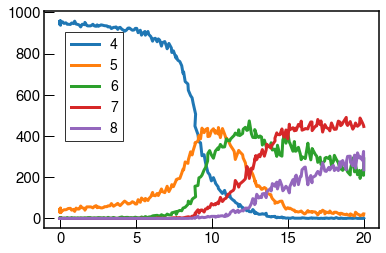

In [29]:
fig, axs = plt.subplots()

for i in range(4,9):
    axs.plot(id_u16_1k.df['f_PressAve']/1e4, cn.T[i][1:], label=str(i))

axs.legend()

In [44]:
sh = Atoms(hexagonal.Hexagonal(symbol='Si', latticeconstant={'a':2.65, 'c':4.58}))
dia = bulk('Si', crystalstructure='diamond', a=5.43,  cubic=True)

In [48]:
sh_kern = kernel_compare(id_u16_1k.df['Configs'], sh, similarity=True, average=True)

In [49]:
dia_kern = kernel_compare(id_u16_1k.df['Configs'], dia, similarity=True, average=True)

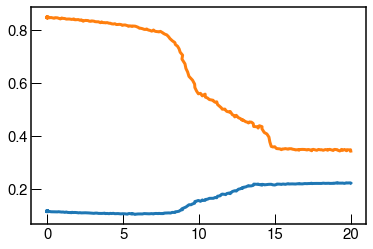

In [51]:
fig, axs = plt.subplots()
axs.plot(id_u16_1k.df['f_PressAve']/1e4, sh_kern)
axs.plot(id_u16_1k.df['f_PressAve']/1e4, dia_kern)

In [94]:
sh_kern_atomwise = kernel_compare(id_u16_1k.df['Configs'], sh, similarity=True, average=False)

RuntimeError: Interrupt occured

In [22]:
len(id_u16_1k.configs), len(id_u16_1k.dat[0])

(252, 255)

In [25]:
len(id_u16_1k.df['f_PressAve'])

251

In [ ]:
id_u16_1k.df['Configs'][0].info


